In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

%matplotlib inline 


In [2]:
def f(x): 
    return 3*x**2 - 4*x +5
    

In [3]:
f(3.0)


20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs


array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

### TIL

`np` has **`a`**`range`

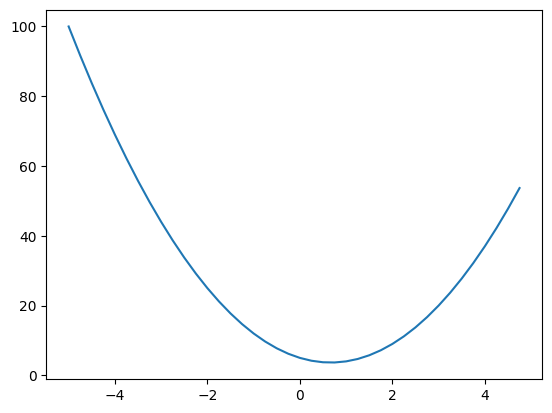

In [5]:
ys = f(xs)
plt.plot(xs, ys); # ; suppresses printing the result


# what is d/dx 

 $f(x) = 3x^2 - 4x + 5$

In NN this isn't the way to compute d/dx

```
d / dx =         f(x + h) - f(x)
          Lm    --------------------
        h->0           h
```
Lets use that 

In [6]:
def find_dx(x): 
    h  = 0.00001
    fx = f(x)
    fx_h = f(x+h)
    df_dx = (fx_h - fx) / h
    return df_dx 
    

find_dx(3.0)


14.00003000000538

## Lets d/dx 

$f(x) = 3x^2 - 4x + 5$

$\frac{df}{dx}  = 6x - 4$

$f'(3.0) =  6\times3.0 - 4$

$ = 18 - 4 = 14$


In [7]:
# how about -3 

find_dx(-3.0) 

-21.999970000052823

# More complex example 

$ d = ab + c $


In [8]:
def fn(a, b, c):
    return a*b + c

# NOTE: d/da (ab + c) = b 

def df_da(a, b, c):
    f = fn(a, b, c)
    
    h = 0.0001
    fa_h = fn(a+h, b, c)

    slope = (fa_h - f) / h
    
    return (f, fa_h, slope)
    
print( "df/da = f: {}, f+h {}, slope: {}".format(*df_da(2.0, -3.0, 10.0)))


df/da = f: 4.0, f+h 3.999699999999999, slope: -3.000000000010772


In [9]:
def df_db(a, b, c): 
    f = fn(a, b, c)
    
    h = 0.0001
    fb_h = fn(a, b+h, c)

    slope = (fb_h - f) / h
    
    return (f, fb_h, slope)
    
print( "f: {}, f+h {}, slope: {}".format(*df_db(2.0, -3.0, 10.0)))



f: 4.0, f+h 4.0002, slope: 2.0000000000042206


In [10]:

def df_dc(a, b, c): 
    f = fn(a, b, c)
    
    h = 0.0001
    fc_h = fn(a, b, c+h)

    slope = (fc_h - f) / h
    
    return (f, fc_h, slope)
    
print( "f: {}, f+h {}, slope: {}".format(*df_dc(2.0, -3.0, 10.0)))


f: 4.0, f+h 4.0001, slope: 0.9999999999976694


# Value Object


In [11]:
class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = f" {op} ".join(x.short_expr for x in parents)

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} v={self.v} )"
        
    def __add__(self, other):
        return Value( v=self.v + other.v,  parents=(self, other),  op="+")

    def __sub__(self, other):
        return Value(v=self.v - other.v, parents=(self, other), op="-")
        
    def __mul__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="*")
        
    def __div__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="/")
        
        




In [12]:
print(Value(3.0), Value(3.0).grad)

Value(: expr= v=3.0 ) 0.0


In [13]:
# adding value objects  ...
a = Value(3.0, label="a")
b = Value(-2.0, label="b")
print(a , b)
print(a + b)
print(a-b)
print(a*b)

Value(a: expr= v=3.0 ) Value(b: expr= v=-2.0 )
Value(: expr=a + b v=1.0 )
Value(: expr=a - b v=5.0 )
Value(: expr=a * b v=-6.0 )


In [14]:
c = Value(10.0, label="c") 
# order of operators is maintained !
print(a*b +c)
print(c + a*b)

Value(: expr=a * b + c v=4.0 )
Value(: expr=c + a * b v=4.0 )


In [15]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    
    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            for child in v.parents:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | %.4f | grad %.4f }" % (n.full_expr, n.v, n.grad), shape='record')
        if n.op:
            dot.node(name=str(id(n)) + n.op, label=n.op)
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    return dot

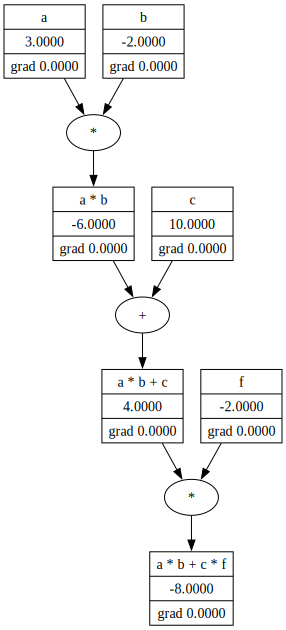

In [16]:
f = Value(-2.0, label="f")
L = (a * b + c) * f
draw_dot(L, rankdir="TB")

# So far ...

* we have built fwd pass
* can visualize the fwd pass graph

# Next .. Backpropogation

* what is dL / dl
* what dL / df
* what is dL / (a*b + c)
* what is dL / dc
* what is dL / da
* what is dL / db

# 

dL / df = (L+h - L) / h  : 4.000000 | d: Value(d: expr=e + c v=4.0 )  


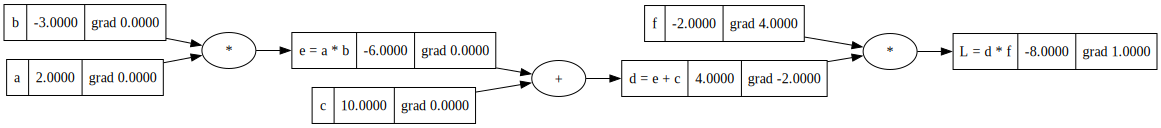

In [17]:
# dl dl

def fnL(a, b, c, f):
    # (a * b + c) * f
    #  | e |  
    #      | d  |
    #  |       L    |     
    e = a*b; e.label = "e"
    d = e + c; d.label = "d"
    L = d * f; L.label = "L"
    
    return (L, e, d) 

    
def dL_df(a, b, c, f):
    L, e, d = fnL(a, b, c, f)
    
    # dL / dL = 1
    L.grad = 1
    # dL / df  
    #  = d/df (f * d) 
    #  =  d
    f.grad = d.v
    
    # my understanding 
    # when L is obtained as a result of * then the "other" is the grad 

    d.grad = f.v

    # find the result numerically
    h = 0.0001
    f_h = Value(f.v + h, "f+h")
    L_h, _, _ = fnL(a, b, c, f_h)
    # this proves dL/df computed using f(x+h) - f(x) / h is exactly d
    print(f"dL / df = (L+h - L) / h  : {(L_h.v  - L.v)/h:4f} | d: {d}  ")
    return L

def grok_dl_df():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b")
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_df(a, b, c, f)
    
L = grok_dl_df()
draw_dot(L)


# Most important step - Chain Rule applied

## What is dL/ dc ?

### We know ...
* dL / dL
* dL / dd

### We can find 
* dd / dc

## So what is dL / dc

### lets find dd/dc

$d = c + e $

$ \frac{dd}{dc} = \frac{dc}{dc} + \frac {de}{dc}  $

$ = 1 $ 

$ \frac{dL}{dc} = \frac{dL}{dd} \times \frac{dd}{dc}$

# Conclusion for `+` operations 

Basically `+` operations just returns 1 and in chain rule, is a more like a 
shortcut to forward the resultant (d's) grad. 



dL / dc = (L+h - L) / h  : -2.000000 | c: Value(c: expr= v=10.0 )  


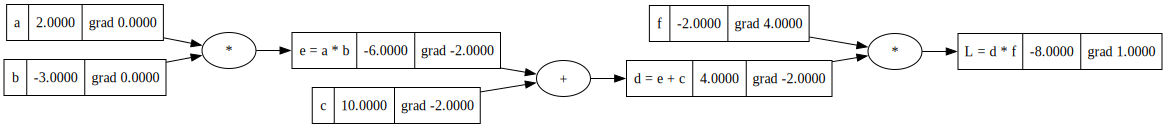

In [18]:
# dl dc
def dL_dd(a, b, c, f):
    L, _, _ = fnL(a, b, c, f)
    h = 0.0001
    a_h = Value(a.v + h, "a+h")
    L_h, _, _ = fnL(a_h, b, c, f)
    print("(L+h - L) / h : ", (L_h.v  - L.v)/h)


    
def dL_dc(a, b, c, f):
    L, e, d = fnL(a, b, c, f)
    
    # dL / dL = 1
    L.grad = 1
    # dL / df  
    #  = d/df (f * d) 
    #  =  d
    f.grad = d.v
    
    # my understanding 
    # when L is obtained as a result of * then the "other" is the grad 
    d.grad = f.v

    # to find dL / dc ... first find 
    #  * dd/dc 
    #  * dL/dd
    #  dL/dc = dL/dd * dd/dc (chainrule) 
    
    # dd / dc 
    # = d/dc (c + e) 
    # = d/dc c + d/dc e 
    # = 1 + 0
    # = 1.0
    
    # so ... df / dc 
    # = dL/dd * dd/dc 
    # = dL/dd * 1
    # = d.grad
    
    c.grad = d.grad
    # similarly  for ... dL/de 
    # = dL/dd  * dd / de 
    #
    # dd / de .. 
    # = d/de (c+e)  => d = c + e
    # = d/e c + d/de e
    # = 0 + 1.0
    e.grad = d.grad

    
    
    h = 0.0001
    c_h = Value(c.v + h, "f+h")
    L_h, _, _ = fnL(a, b, c_h, f)
    # this proves dL/df computed using f(x+h) - f(x) / h is exactly d
    print(f"dL / dc = (L+h - L) / h  : {(L_h.v  - L.v)/h:4f} | c: {c}  ")
    return L

def grok_dl_dc():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b")
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_dc(a, b, c, f)
    
    
L = grok_dl_dc()
draw_dot(L)


(L+h - L) / h :  6.000000000021544


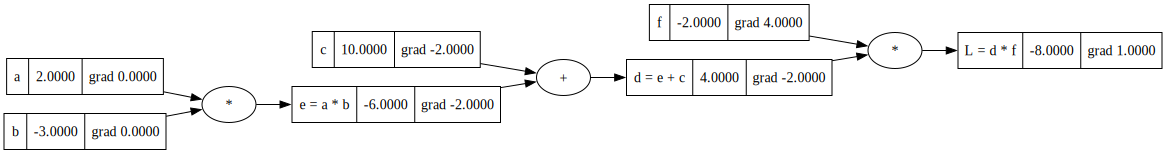

In [19]:

def dL_da(a, b, c, f):
    L, e, d = fnL(a, b, c, f)

    # dL / dL = 1
    L.grad = 1
    # dL / df   = d/df (f * d)  = df/df * dd/df =  d
    f.grad = d.v
    d.grad = f.v

    # to find dL / dc ... first find 
    #  * dd/dc 
    #  * dL/dd
    #  dL/dc = dL/dd * dd/dc (chainrule) 
    
    # dd / dc 
    # = d/dc (c + e) 
    # = d/dc c + d/dc e 
    # = 1 + 0
    # = 1.0
    
    # so ... df / dc 
    # = dL/dd * dd/dc 
    # = dL/dd * 1
    # = d.grad
    
    c.grad = d.grad
    # similarly  for ... dL/de 
    # = dL/dd  * dd / de 
    #
    # dd / de .. 
    # = d/de (c+e)  => d = c + e
    # = d/e c + d/de e
    # = 0 + 1.0
    e.grad = d.grad
    
    h = 0.0001
    a_h = Value(a.v + h, "a+h")
    L_h, _, _ = fnL(a_h, b, c, f)
    
    print("(L+h - L) / h : ", (L_h.v  - L.v)/h)
    return L


def grok_dl_da():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b") 
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_da(a, b, c, f)

L = grok_dl_da()
draw_dot(L)
